<a href="https://colab.research.google.com/github/m-adeleke1/LinkedIn/blob/main/FreeCodeCamp_PyTorch_Projects/FreeCodeCamp_PyTorch_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Initializations and Dataset Download

Lets start by downloading the dataset and installing the necessary library for downloading directly with the link from kaggle.

In [3]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michaeldatasci
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:18<00:00, 123MB/s] 


##2. Imports

Then we will write all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [4]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import librosa # Library that is used to read and process audio files
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import time # Used to calculate time for each epoch or any processing time in seconds
from skimage.transform import resize # Used to resize the images and we will use it to resize audio waves

# detect the GPU if any, if not use CPU, change "cuda" to "mps" if you have a mac
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##3. Data

The dataframe comes with a csv file that contains the path of each audio file and its corresponding label (Quran Reciter). We will read this dataframe.

Then we will modify the path and add the full path to it so that it allows us to read the audio file with respect to colab structure. Then we visualize the first 5 rows of the dataframe.

Keep in mind that this step is not the same for every dataset, you may need to read the dataset differently depends on its structure.

In [5]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv") # Read the original csv as a dataframe

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset/' + data_df['FilePath'].str[1:] # Modify the paths in the dataframe


data_df.head() # Visualize the first 5 rows

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


##4. Data investigation

Now lets dig deeper into our dataset. In the cell below we print the shape of the data which is represented by (rows, columns), then we plot the data distribution for each class. we can see below that our dataset is not 100% balanced but its almost balanced.

Data Shape is:  (6687, 2)


Claases Distrubution is: 


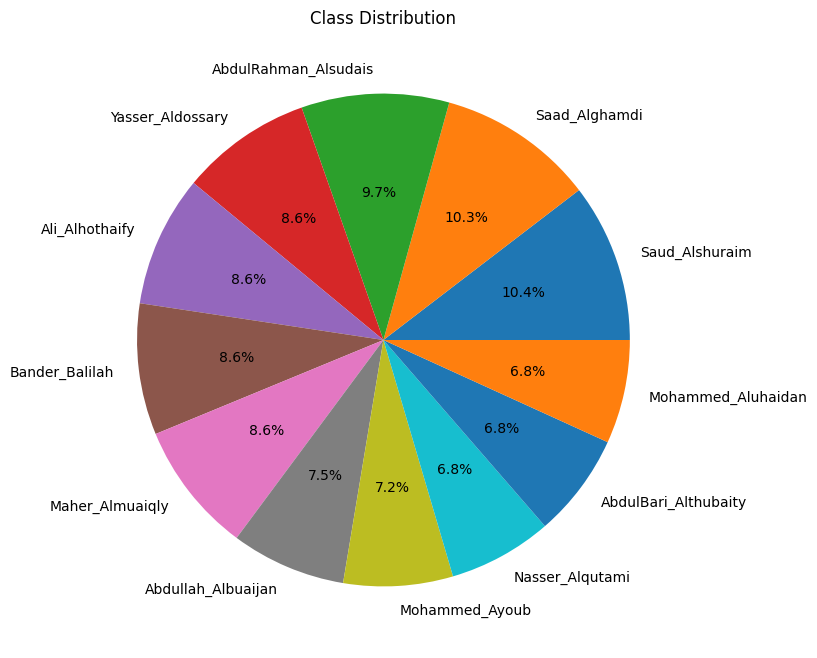

In [6]:
print("Data Shape is: ", data_df.shape) # Print the data shape (rows, columns)
print() # Empty line for better viewing

print() # Empty line for better viewing
print("Claases Distrubution is: ")

class_counts = data_df['Class'].value_counts() # Get how many data sample for each class
plt.figure(figsize=(8, 8)) # Plot a figure of 8 by 8 pixels

# we use this for plotting the how many data sample for each class
# autopct='%1.1f%%' automatically adds a label to each slice of
# the pie with its percentage of the whole, formatted to one decimal place.
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')


plt.title('Class Distribution') # Add title to the whole figure

plt.show() # Visualize/show the figure - Like print()

##5. Data Split

Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using data_df.sample(frac=0.7,random_state=7) then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using data_df.drop(train.index). Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:

Training: 70%
Validation: 15%
Testing: 15%

In [7]:
label_encoder = LabelEncoder() # Defining our label encoder
data_df["Class"] = label_encoder.fit_transform(data_df["Class"]) # Class encoding

train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%


print("Training Shape: ", train.shape) # Print the Trainnig shape (rows, columns)
print("Validation Shape: ", val.shape) # Print the Validation shape (rows, columns)
print("Testing Shape: ", test.shape) # Print the Testing shape (rows, columns)

Training Shape:  (4681, 2)
Validation Shape:  (1003, 2)
Testing Shape:  (1003, 2)


##6. Custom Dataset Class

Now lets create some preprocessing objects, first we start by LabelEncoder which converts string classes to numeric for example instead of having the classes as (x, y) it will be (0,1) because machines understands numbers only.

__init__(self, dataframe): When you create an instance of CustomAudioDataset, you need to provide a dataframe (a kind of table with data that we read before). Inside this function:

self.dataframe: stores the provided dataframe.
self.labels: converts the 'Class' column of the dataframe into numeric values with the label encoder we created before. Then moving them to the device (like a GPU cuda we defined before) for faster computation.
self.audios: loads the audio files listed in the 'FilePath' column of the dataframe and converts each audio file into a spectrogram (a visual representation of the spectrum of frequencies in the audio file).
__len__(self): This function tells you how many items are in the dataset. Keep in mind that this function is available in the original Dataset class in PyTorch but with the concept of inheritance, we are taking this function and overwriting it.

__getitem__(self, idx): This function is used to get a specific item from the dataset by its index (idx). It retrieves the audio and its corresponding label for the given index and prepares them in the required format for the machine learning model. Keep in mind that this function is available in the original Dataset class in PyTorch but we also are taking this function and overwriting it.

get_spectrogram(self, file_path): This is a helper function to convert an audio file into a spectrogram. It involves several steps:

Loading the audio file.
Computing its spectrogram, which is a visual way to represent the different frequencies present in the audio.
Converting the spectrogram to a decibel (dB) scale, which makes it easier to visualize.
Resizing the spectrogram to a fixed size, which is necessary because the machine learning model expects inputs of a consistent size.

In [8]:
class CustomAudioDataset(Dataset):
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.labels = torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
    self.audios = [torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = (self.audios[idx]).unsqueeze(0).to(device)
    return audio, label

  def get_spectrogram(self, file_path):
    sr = 22050 # Set the sample rate of the audio file
    duration = 5 # Set the duration of the audio files

    # Set the size of the spectrogram images
    img_height = 128
    img_width = 256

    # Load the audio file
    signal, sr = librosa.load(file_path, sr=22050, duration=duration)

    # Compute the spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    # Convert the spectrogram to dB scale
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Resize the spectrogram to the desired shape
    spec_resized = librosa.util.fix_length(spec_db, size = duration * sr // 512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

##7. Create Dataset Objects

In this cell we will create 3 objects from the dataset class we created before. Those will be for training, validation and testing.

In [9]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

##8. Hyperparameters

Now we are setting the training hyperparameters, we defined some variables which are the learning rate, batch size and training epoch.

In [10]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

##9. DataLoaders

PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training. Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

##10. Model

This code defines a neural network class named Net which inherits from the class nn.module in PyTorch.

__init__(self): This is where the neural network is set up. Each layer of the network is defined here. self.conv1, self.conv2, self.conv3: These are convolutional layers. They are particularly good at processing data that has a grid-like topology, like images (or in this case, spectrograms from audio data). They work by sliding a small window over the input and transforming the section of data within this window at each step. self.pooling: This is a pooling layer, which reduces the size of the input it's given, helping the network to focus on the most important information. self.relu: This is an activation function that introduces non-linearity into the network (helping it learn complex patterns). self.flatten: This layer flattens the output of the previous layers into a one-dimensional array, which can then be fed into traditional dense (fully connected) layers. self.linear1, self.linear2, self.linear4: These are dense layers, where each neuron is connected to all neurons in the previous layer. They are good at learning complex relationships in data. self.output: This is the final layer that outputs predictions. The number of neurons here is equal to the number of unique classes in your data. self.dropout: This is a dropout layer, used to prevent overfitting (where the model learns the training data too well and performs poorly on new, unseen data).

The firsr linear layer is taking the shape from the flatten, how we calculate the input shape? We know well from the function get_spectrogram in CustomAudioDataset that the input height is 128, and width is 256. So we keep reducing them by the following (1 is the input channel which is only 1 channel):

Starting by (1,128,256)
After conv1 will be (16,128,256)
After first pooling will be (16,64,128)
After conv2 will be (32,64,128)
After second pooling will be (32,32,64)
After conv3 will be (64,32,64)
After third pooling will be (64,16,32) So as per this flow, we know that the firsr linear layer input size is (64 x 16 x 32)
forward(self, x): This function defines how the data flows through the network (from input to output). The data (x) is passed through each layer in the order they were defined in init. After each convolutional and pooling layer, the data's shape changes. After passing through all the layers, the network returns its final output.

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device


print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


##11. Model Summary

This cell is optional, here we show only the summary of the model and what is the output size for each layer. keep in mind that -1 here will be replaced by the batch size.

In [13]:
from torchsummary import summary # Visualize the model layers and number of parameters
summary(model, (1, 128, 256)) # Visualize the model layers by taking the input size expected (-1 in the output will be replaced by the batch size in training)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

##12. Loss and Optimizer

In the cell below, we will create the loss function which will be the Cross Entropy loss. Also we will have create the Adam optimizer and we will provide to it the parameters of the model we created together with the learning rate.

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

##13. Training

Now comes the training part. If you know well the training process of deep learning. You will just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs which we defined before. But before that we define 4 lists and inside the loop we define another 4 variables.

Variables:
total_acc_train: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

total_loss_train: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

total_acc_val: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

total_loss_val: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

Lists:
total_acc_train_plot: We append the losses of the training accuracy to visualize them at the end.

total_loss_train_plot: We append the losses of the training to visualize them at the end.

total_acc_validation_plot: We append the losses of the validation accuracy to visualize them at the end.

total_loss_validation_plot: We append the losses of the validation to visualize them at the end.

Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We add the loss amount to total_loss_train. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the total_acc_train. Then we do the batch_loss.backward() which makes the backpropagation and we use the optimizer to do a step on the weights using optimizer.step() and then we reset the optimizer gradients using optimizer.zero_grad() which is a very important step that has to be done before proceeding.

After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with torch.no_grad() so that we freeze the weights, which means that we need the model to do predicitons without being trained. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. Accuracies are calculated by dividing the right predictions by the complete number of samples and multiplying by 100. Losses are being divided by 1000 just to normalize the values and avoid large values.

In [15]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch


for epoch in range(EPOCHS):
  start_time = time.time() # We use this to calculate the time of each epoch, it starts a counter once called
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  epoch_string = f"""
                  Epoch: {epoch+1}/{EPOCHS},
                  Train Loss: {round(total_loss_train/100, 4)},
                  Train Accuracy: {round((total_acc_train/train_dataset.__len__() * 100), 4)},
                  Validation Loss: {round(total_loss_val/100, 4)},
                  Validation Accuracy: {round((total_acc_val/val_dataset.__len__() * 100), 4)}
                  """
  print(epoch_string)
  print("="*30)


                  Epoch: 1/25, 
                  Train Loss: 18.5871, 
                  Train Accuracy: 11.0446, 
                  Validation Loss: 1.5601, 
                  Validation Accuracy: 11.9641
                  

                  Epoch: 2/25, 
                  Train Loss: 7.1507, 
                  Train Accuracy: 12.0273, 
                  Validation Loss: 1.5208, 
                  Validation Accuracy: 12.3629
                  

                  Epoch: 3/25, 
                  Train Loss: 7.0323, 
                  Train Accuracy: 13.4373, 
                  Validation Loss: 1.5141, 
                  Validation Accuracy: 13.659
                  

                  Epoch: 4/25, 
                  Train Loss: 6.8721, 
                  Train Accuracy: 16.0649, 
                  Validation Loss: 1.4199, 
                  Validation Accuracy: 22.0339
                  

                  Epoch: 5/25, 
                  Train Loss: 6.3548, 
                  Train 

##14. Testing

Now in this section, we will be testing our model, we will start the code by with torch.no_grad(): which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (cuda) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [16]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 91.53%


##15. Plotting Training Progress

Let's plot the training and validation progress through out the EPOCHS. The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

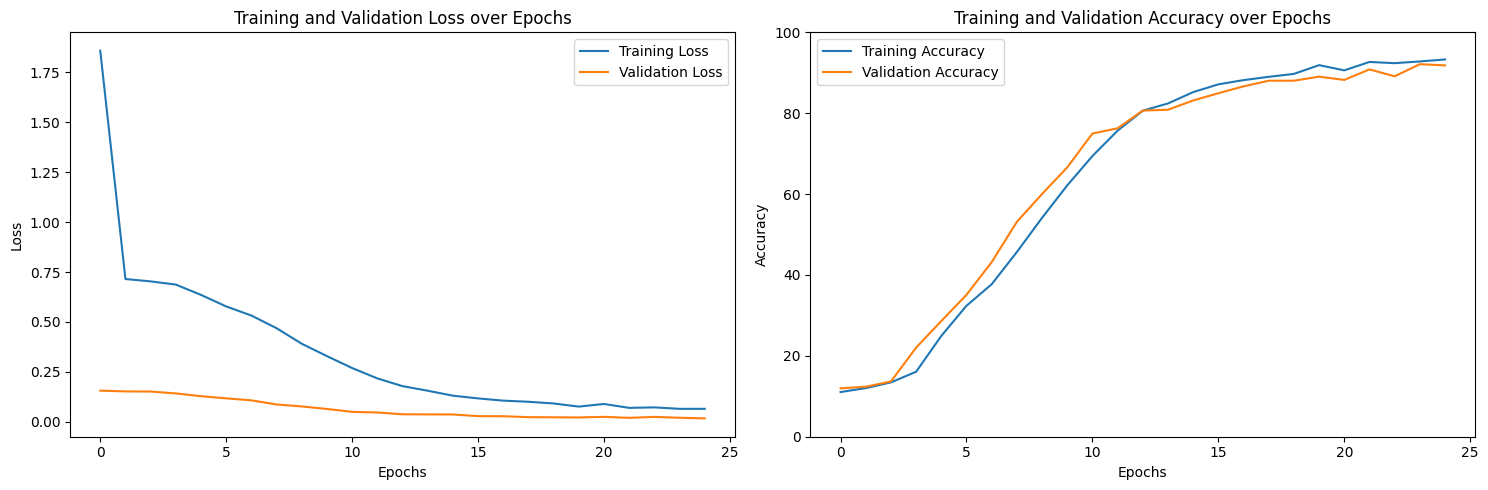

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()